In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pyogrio

pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv', on_bad_lines="warn", delimiter=";")
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


As our hypothetical use case, we imagine a government agency that is interested to predict how much endangered fish a given catch operation has caught.

We used "https://artsdatabanken.no/lister/rodlisteforarter/2021?Name=&SortBy=ScientificName&Meta=Visited&Meta=scroll_658&IsCheck=Area&Area=N&IsCheck=Category&Category=CR&Category=EN&IsCheck=SpeciesGroups&SpeciesGroups=Fisker&IsCheck=Insekter" to find endangered species of fish. 

Three of these are included in the dataset:

1. Vanlig Uer
2. Blålange
3. Ål

Our strategy will be to trim unnecessary columns, turn species into boolean columns and have machine learning models predict the amount (weight) caught of the given species for each catch operation.

<!-- A lot of the data in the columns needs to be converted into boolean and number values, and some needs to be omitted due to inaccuracies.  -->



In [7]:
# df.info()
uer_df = df[df['Art FAO'] == "Uer (vanlig)"] 
blålange_df = df[df['Art FAO'] == "Blålange"] 
ål_df = df[df['Art FAO'] == "Ål"] 
print("Number of catches containing Uer: ", len(uer_df))
print("Number of catches containing Blålange: ", len(blålange_df))
print("Number of catches containing Ål: ", len(ål_df))


Number of catches containing Uer:  14153
Number of catches containing Blålange:  991
Number of catches containing Ål:  2


There are only two catch operations containing Ål, we need more data in order to predict for this species.
For Blålange and Uer we can move on. It's difficult to say beforehand wether or not 991 positive datapoints will be enough to accurately predict the Rundvekt of Blålange, but it's within the realm of possibilities.
 
To begin trimming down the amount of data, we can safely drop columns where the data is already present in other columns

In [8]:
df = df.drop(labels=["Meldingsdato","Meldingsklokkeslett","Startdato","Startklokkeslett", "Stoppdato", "Stoppklokkeslett", "Lengdegruppe (kode)", "Lengdegruppe"], axis=1)
df = df.drop(labels=["Hovedart FAO (kode)","Hovedart FAO","Hovedart - FDIR (kode)","Art - gruppe","Art - gruppe (kode)", "Art - FDIR (kode)", "Art - FDIR", "Redskap FDIR (kode)", "Redskap FDIR"], axis=1)



We notice that Start/Stop times are inconsistent. We therefore filter out Start/Stop times which do not contain ':'. This way we can trust the 'Varighet' column more.

Furthermore, 'Fartøylengde', 'Bredde', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde' is written with ',' and not '.'. We change ',' to '.' and cast to float datatype.

In [9]:
df = df[df["Starttidspunkt"].str.contains(":")]
df = df[df["Stopptidspunkt"].str.contains(":")]

castable_columns = ["Fartøylengde", "Bredde", "Startposisjon bredde", "Startposisjon lengde", "Stopposisjon bredde", "Stopposisjon lengde"]

for column in castable_columns:
    df[column] = df[column].str.replace(",", ".").astype("float")



Next we need to convert the categorical column values we _do_ want to use into machine-readable data. In this case we use the built-in get_dummies function to create boolean columns.

In [10]:
species_columns = pd.get_dummies(df["Art FAO"], dtype="float")
species_columns_multiplied = species_columns.multiply(df["Rundvekt"], axis="index")

endangered_species_1 = species_columns_multiplied["Uer (vanlig)"]
endangered_species_2 = species_columns_multiplied["Blålange"]

df = pd.concat([df,endangered_species_1 ], axis=1)
df = pd.concat([df,endangered_species_2 ], axis=1)

tool_columns = pd.get_dummies(df["Redskap FAO"])


df = pd.concat([df,tool_columns], axis=1) 

# Checking count of the diffrent tools used before grouping
boolean_columns = df.select_dtypes(include=['bool']).columns
counts = {col: df[col].value_counts() for col in boolean_columns}
for col, count in counts.items():
    print(f"Value counts for {col}:\n{count}\n")



Value counts for Andre liner:
Andre liner
False    279412
True      23579
Name: count, dtype: int64

Value counts for Annen trål (udefinert):
Annen trål (udefinert)
False    302741
True        250
Name: count, dtype: int64

Value counts for Boat /vessel seines -Pair seines:
Boat /vessel seines -Pair seines
False    302053
True        938
Name: count, dtype: int64

Value counts for Bunntrål (uspes):
Bunntrål (uspes)
False    290216
True      12775
Name: count, dtype: int64

Value counts for Bunntrål, otter:
Bunntrål, otter
False    182849
True     120142
Name: count, dtype: int64

Value counts for Bunntrål, par:
Bunntrål, par
False    299656
True       3335
Name: count, dtype: int64

Value counts for Bunntrål, reke:
Bunntrål, reke
False    281394
True      21597
Name: count, dtype: int64

Value counts for Dorg/harp/snik:
Dorg/harp/snik
False    302975
True         16
Name: count, dtype: int64

Value counts for Encircling gillnets*:
Encircling gillnets*
False    302647
True        344
Na

In [11]:
df.head()

,Melding ID,Meldingstidspunkt,Starttidspunkt,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Art FAO (kode),Art FAO,Rundvekt,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde,Uer (vanlig),Blålange,Andre liner,Annen trål (udefinert),Boat /vessel seines -Pair seines,Bunntrål (uspes),"Bunntrål, otter","Bunntrål, par","Bunntrål, reke",Dorg/harp/snik,Encircling gillnets*,"Flytetrål, otter","Flytetrål, par","Flytetrål, reke","Flytetrål, uspesifisert",Gillnets and entangling nets (unspec)*,"Harpun,div.","Juksa/pilk, manuell",Otter dobbeltrål,"Partrål, uspesifisert",Settegarn,Setteline,"Skrape, mekanisert",Snurpenot/ringnot,"Snurpenot/ringnot, et fartøy","Snurpenot/ringnot, to fartøy",Snurrevad,"Snurrevad, dansk","Snurrevad, skotsk",Teiner,Udefinert garn,Udefinert trål
1,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",HAD,Hyse,9594.0,1476.0,NaN,12.6,56.8,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",COD,Torsk,8510.0,1476.0,NaN,12.6,56.8,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",GHL,Blåkveite,196.0,1476.0,NaN,12.6,56.8,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",POK,Sei,134.0,1476.0,NaN,12.6,56.8,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,1497178,01.01.2018,31.12.2017 05:48,74.910,15.868,20.0,Bjørnøya,7.0,-403,31.12.2017 10:15,267,2017,74.901,16.248,20.0,Bjørnøya,7.0,-277,11096.0,OTB,"Bunntrål, otter",HAD,Hyse,9118.0,1476.0,NaN,12.6,56.8,0.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
#grouping all relevant tools used
columns_to_group = ['Bunntrål (uspes)', 'Bunntrål, otter', 'Bunntrål, par','Bunntrål, reke','Skrape, mekanisert', 'Otter dobbeltrål', 'Otter dobbeltrål']

df['DivBunntrål'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Snurrevad, skotsk', 'Snurrevad, dansk', 'Snurrevad']

df['DivSnurrevad'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Snurpenot/ringnot, to fartøy', 'Snurpenot/ringnot, et fartøy', 'Snurpenot/ringnot', 'Boat /vessel seines -Pair seines']

df['DivSnurpenot/ringnot'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Flytetrål, otter', 'Flytetrål, par', 'Flytetrål, reke','Flytetrål, uspesifisert']

df['DivFlytetrål'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Udefinert garn', 'Settegarn', 'Gillnets and entangling nets (unspec)*','Encircling gillnets*']

df['DivGarn'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Andre liner', 'Setteline', 'Dorg/harp/snik','Juksa/pilk, manuell']

df['DivLine'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Harpun,div.', 'Partrål, uspesifisert', 'Teiner','Udefinert trål','Annen trål (udefinert)']

df['Annet'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)



In [13]:
species_dict = {
    "Uer (vanlig)": "sum",
    "Blålange": "sum",
}
tool_dict= dict.fromkeys(['Annet','DivBunntrål','DivSnurrevad','DivSnurpenot/ringnot','DivFlytetrål','DivGarn','DivLine'], "first")

catch_dict = {
        "Varighet": "mean",
        "Fangstår": "mean",
        "Trekkavstand": "mean",
        "Bredde": "mean",
        "Fartøylengde" : "mean",
        "Bruttotonnasje": "mean",
        "Rundvekt": "sum",
        "Havdybde start": "sum",
        "Havdybde stopp": "sum",
        "Startposisjon lengde": "sum",
        "Startposisjon bredde": "sum",
        "Stopposisjon lengde": "sum",
        "Stopposisjon bredde": "sum",

    }
master_dict = {**catch_dict, **tool_dict, **species_dict }

In [14]:
# checking count of tools after grouping 
boolean_columns = df.select_dtypes(include=['bool']).columns
counts = {col: df[col].value_counts() for col in boolean_columns}
for col, count in counts.items():
    print(f"Value counts for {col}:\n{count}\n")



Value counts for DivBunntrål:
DivBunntrål
True     161147
False    141844
Name: count, dtype: int64

Value counts for DivSnurrevad:
DivSnurrevad
False    252340
True      50651
Name: count, dtype: int64

Value counts for DivSnurpenot/ringnot:
DivSnurpenot/ringnot
False    289350
True      13641
Name: count, dtype: int64

Value counts for DivFlytetrål:
DivFlytetrål
False    295975
True       7016
Name: count, dtype: int64

Value counts for DivGarn:
DivGarn
False    283154
True      19837
Name: count, dtype: int64

Value counts for DivLine:
DivLine
False    260585
True      42406
Name: count, dtype: int64

Value counts for Annet:
Annet
False    294886
True       8105
Name: count, dtype: int64


In [15]:
# remove their original counterpart 
df = df.drop(["Art FAO", "Redskap FAO", "Art FAO (kode)", "Redskap FAO (kode)"], axis=1)

It's natural to think that the size of the vessel is important for predicting how much fish is caught.

In order to use 'Bruttotonnasje' one option is to pick one of the columns, delete the other one and drop all n/a values.

We decided on a slightly different approach in order to preserve more rows.
We base the 'Bruttotonnasje' value on the standard 'Bruttotonnasje 1969' and instead of dropping rows right away, we check if the row contains a value in 'Bruttotonnasje annen', and use that.
Rows with missing values in both columns are dropped.


In [16]:

df = df.dropna(subset=["Bruttotonnasje 1969", "Bruttotonnasje annen"], how='all')
df["Bruttotonnasje"] = df["Bruttotonnasje 1969"].fillna(df["Bruttotonnasje annen"])
df = df.drop(["Bruttotonnasje 1969", "Bruttotonnasje annen"], axis=1)


It should be noted that 'Bruttotonnasje' is pretty well explained by 'Fartøylengde', although in a non-linear fashion. In light of this, we could probably omit either 'Bruttotonnasje' or the boat dimensions.
See graph.

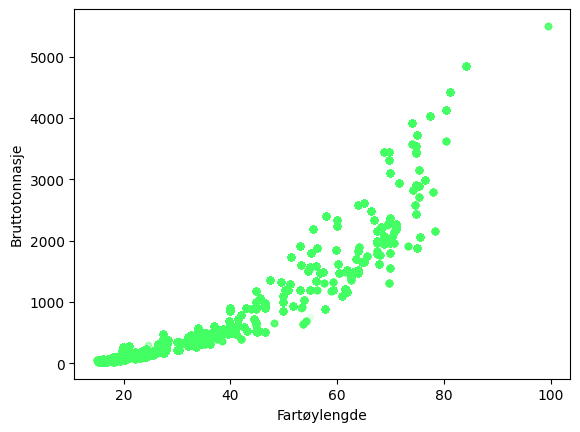

In [17]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Bruttotonnasje', c="#43ff640d")
plt.show()

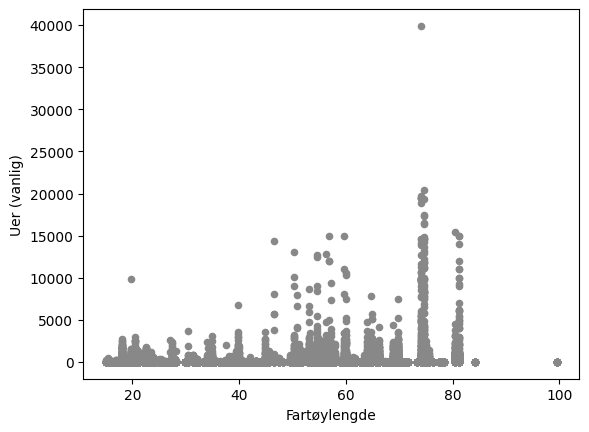

In [18]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Uer (vanlig)', c="#888")
plt.show()

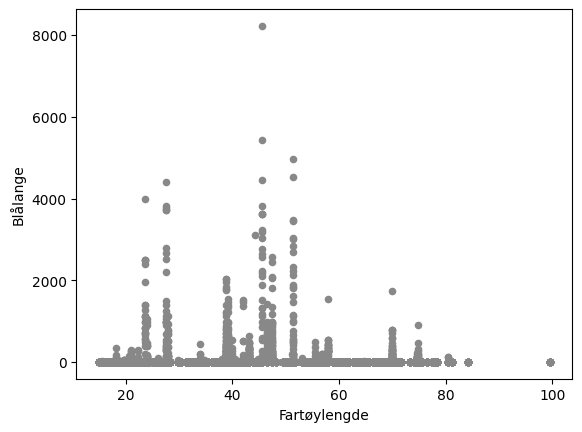

In [19]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Blålange', c="#888")
plt.show()

In [20]:
grouped = df.groupby(by=["Melding ID", "Starttidspunkt", "Stopptidspunkt"]).agg(master_dict).reset_index()
grouped.shape
grouped

,Melding ID,Starttidspunkt,Stopptidspunkt,Varighet,Fangstår,Trekkavstand,Bredde,Fartøylengde,Bruttotonnasje,Rundvekt,Havdybde start,Havdybde stopp,Startposisjon lengde,Startposisjon bredde,Stopposisjon lengde,Stopposisjon bredde,Annet,DivBunntrål,DivSnurrevad,DivSnurpenot/ringnot,DivFlytetrål,DivGarn,DivLine,Uer (vanlig),Blålange
0,1497178,30.12.2017 23:21,31.12.2017 04:16,295.0,2017.0,3970.0,12.60,56.80,1476.0,18434.0,-1340,-1336,64.192,299.540,63.876,299.656,False,True,False,False,False,False,False,0.0,0.0
1,1497178,31.12.2017 05:48,31.12.2017 10:15,267.0,2017.0,11096.0,12.60,56.80,1476.0,16062.0,-2418,-1662,95.208,449.460,97.488,449.406,False,True,False,False,False,False,False,0.0,0.0
2,1497178,31.12.2017 11:34,31.12.2017 16:49,315.0,2017.0,10215.0,12.60,56.80,1476.0,17878.0,-2076,-2976,96.336,449.298,94.452,449.544,False,True,False,False,False,False,False,37.0,0.0
3,1497178,31.12.2017 17:44,31.12.2017 21:47,243.0,2017.0,3214.0,12.60,56.80,1476.0,13780.0,-886,-716,31.570,149.862,31.788,149.852,False,True,False,False,False,False,False,0.0,0.0
4,1497229,01.01.2018 10:01,01.01.2018 11:04,63.0,2018.0,1269.0,5.06,19.10,51.0,4.0,-71,-56,12.972,67.828,12.942,67.827,False,False,True,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98238,1800286,31.12.2018 15:07,31.12.2018 18:59,232.0,2018.0,2400.0,10.50,39.79,691.0,9023.0,-764,-712,88.564,283.448,88.752,283.508,False,True,False,False,False,False,False,0.0,0.0
98239,1800291,30.12.2018 23:20,31.12.2018 04:21,301.0,2018.0,13284.0,12.60,57.30,1483.0,11105.0,-1544,-2728,114.360,612.072,117.432,611.448,False,True,False,False,False,False,False,51.0,0.0
98240,1800291,31.12.2018 05:40,31.12.2018 11:25,345.0,2018.0,44035.0,12.60,57.30,1483.0,10017.0,-1708,-2093,104.524,534.695,95.494,536.480,False,True,False,False,False,False,False,51.0,0.0
98241,1800291,31.12.2018 12:53,31.12.2018 18:21,328.0,2018.0,41216.0,12.60,57.30,1483.0,10427.0,-1400,-1445,69.000,383.030,64.100,384.495,False,True,False,False,False,False,False,102.0,0.0


In [21]:
#df.plot(kind = 'scatter', x = 'Startposisjon lengde', y = 'Startposisjon bredde', c="Uer (vanlig)")
#df.plot()
#countries.plot(color="lightgrey")

#plt.show()

In [22]:
df = df.drop(df[df["Startposisjon lengde"] < -50].index)
df = df.drop(df[df["Startposisjon lengde"] > 60].index)
df = df.drop(df[df["Startposisjon bredde"] < 40].index)
df = df.drop(df[df["Uer (vanlig)"] > 25000].index) # Outlier


/var/folders/vc/3x4nt6w91vb8xw0gvcj8vcj40000gn/T/ipykernel_17381/3351875174.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


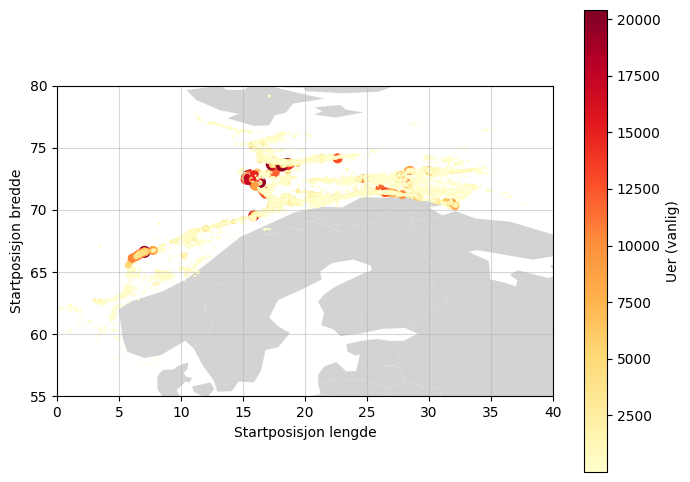

In [23]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)
df_positive_uer = df.drop(df[df["Uer (vanlig)"] == 0].index)

# plot points
df_positive_uer.plot(x="Startposisjon lengde", y="Startposisjon bredde", kind="scatter", 
        c="Uer (vanlig)", colormap="YlOrRd", s=df_positive_uer["Uer (vanlig)"].multiply(0.003),
        ax=ax)
# add grid
ax.grid( alpha=0.5)
ax.set_xlim(0, 40)
ax.set_ylim(55, 80)
plt.show()

/var/folders/vc/3x4nt6w91vb8xw0gvcj8vcj40000gn/T/ipykernel_17381/4277941055.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


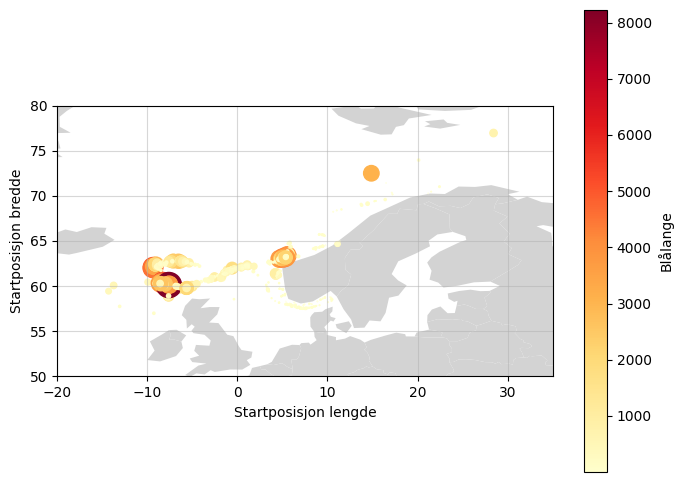

In [24]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)

df_positive_lange = df.drop(df[df["Blålange"] == 0].index)
# plot points
df_positive_lange.plot(x="Startposisjon lengde", y="Startposisjon bredde", kind="scatter", 
        c="Blålange", colormap="YlOrRd", s=df_positive_lange["Blålange"].multiply(0.04),
        ax=ax)
# add grid
ax.grid( alpha=0.5)
ax.set_xlim(-20, 35)
ax.set_ylim(50, 80)
plt.show()

In [25]:
grouped.corr(method="pearson", numeric_only=True)["Uer (vanlig)"]

Melding ID              0.013067
Varighet               -0.013552
Fangstår                0.000585
Trekkavstand            0.002846
Bredde                  0.092497
Fartøylengde            0.079899
Bruttotonnasje          0.102637
Rundvekt               -0.011323
Havdybde start         -0.082048
Havdybde stopp         -0.087472
Startposisjon lengde    0.079031
Startposisjon bredde    0.070672
Stopposisjon lengde     0.079375
Stopposisjon bredde     0.070738
Annet                  -0.031622
DivBunntrål             0.082644
DivSnurrevad           -0.051038
DivSnurpenot/ringnot   -0.037881
DivFlytetrål           -0.020917
DivGarn                 0.014277
DivLine                 0.000869
Uer (vanlig)            1.000000
Blålange                0.007428
Name: Uer (vanlig), dtype: float64

**Supervised Learning**

TODO: Preprocessing of data with reasoning 

TODO: Build 3 supervised learning models, one of which needs to be a deep learning model

KNN (regressor), nevralt nett (deep learning, pytorch, keras, tensorflow), spicy learning model 

**Unsupervised Learning (Clustering Model)**

TODO: Preprocessing of data with reasoning

TODO: Build Clustering Model 

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier  # For classification
from sklearn.neighbors import KNeighborsRegressor  # For regression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

df_knn = df


In [27]:
# TODO gjøre om kolonnene under til dummies slik at de kan brukes i knn modellen, er det for eksempel relevant hvilken måned det er blitt fisket i?

df_knn.drop(columns=['Meldingstidspunkt', 'Starttidspunkt','Hovedområde start', 'Stopptidspunkt','Hovedområde stopp'], inplace=True)

# fjerner nan rows 
df_knn = df_knn.dropna()


In [28]:
X = df_knn.drop('Uer (vanlig)', axis=1)
y = df_knn['Uer (vanlig)']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
df_knn.head()

,Melding ID,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Lokasjon start (kode),Havdybde start,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Rundvekt,Bredde,Fartøylengde,Uer (vanlig),Blålange,DivBunntrål,DivSnurrevad,DivSnurpenot/ringnot,DivFlytetrål,DivGarn,DivLine,Annet,Bruttotonnasje
1,1497178,74.885,16.048,20.0,7.0,-335,295,2017,74.914,15.969,20.0,7.0,-334,3970.0,9594.0,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False,1476.0
2,1497178,74.885,16.048,20.0,7.0,-335,295,2017,74.914,15.969,20.0,7.0,-334,3970.0,8510.0,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False,1476.0
3,1497178,74.885,16.048,20.0,7.0,-335,295,2017,74.914,15.969,20.0,7.0,-334,3970.0,196.0,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False,1476.0
4,1497178,74.885,16.048,20.0,7.0,-335,295,2017,74.914,15.969,20.0,7.0,-334,3970.0,134.0,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False,1476.0
5,1497178,74.910,15.868,20.0,7.0,-403,267,2017,74.901,16.248,20.0,7.0,-277,11096.0,9118.0,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False,1476.0


In [31]:
df_knn.dtypes

Melding ID                    int64
Startposisjon bredde        float64
Startposisjon lengde        float64
Hovedområde start (kode)    float64
Lokasjon start (kode)       float64
Havdybde start                int64
Varighet                      int64
Fangstår                      int64
Stopposisjon bredde         float64
Stopposisjon lengde         float64
Hovedområde stopp (kode)    float64
Lokasjon stopp (kode)       float64
Havdybde stopp                int64
Trekkavstand                float64
Rundvekt                    float64
Bredde                      float64
Fartøylengde                float64
Uer (vanlig)                float64
Blålange                    float64
DivBunntrål                    bool
DivSnurrevad                   bool
DivSnurpenot/ringnot           bool
DivFlytetrål                   bool
DivGarn                        bool
DivLine                        bool
Annet                          bool
Bruttotonnasje              float64
dtype: object

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:

knn_regressor = KNeighborsRegressor(n_neighbors=10)
knn_regressor.fit(X_train_scaled, y_train)


KNeighborsRegressor(n_neighbors=10)

In [34]:

y_pred = knn_regressor.predict(X_test_scaled)
print("MSE:", mean_squared_error(y_test, y_pred))


MSE: 53254.125927101086


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F


df_pytorch = df

X = df_pytorch.drop('Uer (vanlig)', axis=1).values
y = df_pytorch['Uer (vanlig)'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# If your target is a single value, ensure it's the correct shape
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)


In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64) # Adjust input features accordingly
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1) # Predicting a single amount value

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()


In [42]:
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [43]:
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: nan
Epoch 11, Loss: nan
Epoch 21, Loss: nan
Epoch 31, Loss: nan
Epoch 41, Loss: nan
Epoch 51, Loss: nan
Epoch 61, Loss: nan
Epoch 71, Loss: nan
Epoch 81, Loss: nan
Epoch 91, Loss: nan


In [45]:
with torch.no_grad():
    predicted = model(X_test)
    loss = criterion(predicted, y_test)
    print(f'Test Loss: {loss.item()}')


Test Loss: nan


**Results and comments**

TODO: "write a summary of your results, and discuss consequences of such results."
